In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

import pandas as pd

1 Physical GPUs, 1 Logical GPUs


In [2]:
from pde_solvers.cn import *
from local_utils import *
from turing.three_nodes_circuits import create_circuit_3954

# Load the parameters

In [3]:
df = pd.read_csv("df_network_analysis.csv")
df["adj_tup"] = df["adj_tup"].apply(lambda x: eval(f"tuple({x})"))
df["Adj"] = df["adj_tup"].apply(lambda x: np.array(x).reshape((3,3)))

In [4]:
adj=np.array([[1, 1, -1], [-1, 0, -1], [0, -1, 1]])
subnet_list = [g[1] for g in df.groupby("adj_tup") if g[0] == tuple(adj.flatten())]
if len(subnet_list) == 0:
    print("================================")
    print("There is no adjacancy matrix as: ", adj)
    print("================================")
else:
    subnet_df = subnet_list[0]

In [5]:
with open('turing_parameters.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('outputs/indices.npy', 'rb') as f:
    indices = np.load(f)
    

In [6]:
subnet_df.head(1)

,min_A,min_B,min_C,avg_A,avg_B,avg_C,max_A,max_B,max_C,std_A,...,lb_CB,ub_CB,state_CC,lb_CC,ub_CC,Adj,k_max,params,path,adj_tup
116,0.879311,27.4671,2.00005,3.859942,31.707845,2.000238,6.759598,35.970982,2.000543,1.49011,...,1.780018,56.210562,Active,0.880009,28.110281,"[[1, 1, -1], [-1, 0, -1], [0, -1, 1]]",8.430177,[4.0e+00 1.0e-03 1.0e-01 5.0e+00 5.0e+00 5.0e+...,outputs_second_search/solution_10_0_24.npy,"(1, 1, -1, -1, 0, -1, 0, -1, 1)"


In [7]:
def load_dataset(path):
    with open(f"{path}", "rb") as f:
        k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return (params, res, k_max)

In [25]:
def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)

def rmse(arr1, arr2):
    return np.sqrt(np.mean((arr1-arr2)**2))


def G(sigma, x, y):
    gaussian = (1/(2*np.pi*sigma**2))*np.exp(-(x**2+y**2)/(2*sigma**2))
    return gaussian

def G_discrete(sigma, n):
    l = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            l[i,j] = G(sigma, (i-(n-1)/2),(j-(n-1)/2))
    return l

def G_discrete_normalise(sigma, n):
    l = G_discrete(sigma, n)
    return l/np.sum(l)

def simulation(index,
               obserrvaion_sigma = 1.2,
               LoG_sigma = .75,
               test_validation_ratio=0.8,
               noise_level=0,
               batch_size=128*128,
               slice_min = 65, 
               slice_max = 100,
               epochs=20000+1, epochs2=20000+1, epochs3=20000+1,  
               run="1"):
    print("######################################################")
    path = subnet_df["path"].iloc[index]
    print(index, path)
    (params, res, k_max) = load_dataset(path)
    plot_n_im([to(res[-1, 0, :]), to(res[-1, 1, :]), to(res[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()
    
    T=1    
    L=10
    data = reshape(res, T)
    nodes_n = data.shape[0]
    node_names = ["A", "B", "C"]
    x_size = data.shape[1]
    y_size = data.shape[2]
    ##########################################
    # Create a mesh that is the centers of the
    # original mesh
    x_size -= 1
    y_size -= 1
    dxdy = L**2/((x_size-1)*(y_size-1))
    ##########################
    N = x_size*y_size    
    t_star = np.arange(T, T+1)
    ##########################
    x_slice = slice(slice_min, slice_max, 1)
    y_slice = slice(slice_min, slice_max, 1)


    x_range = L * np.linspace(0, 1, x_size)[x_slice]
    y_range = L * np.linspace(0, 1, y_size)[y_slice]

    block_x = x_range.shape[0]
    block_y = y_range.shape[0]

    x = tf.constant(x_range, dtype=tf.float32)
    y = tf.constant(y_range, dtype=tf.float32)
    # The order of the Y and X must be reversed,
    # since the chnages the value finds the derivatives
    #Y, X = tf.meshgrid(x, y)

    X, Y = tf.meshgrid(x, y)
    ts = tf.constant(t_star, dtype=tf.float32)
    T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
    def H_cube(X, Y, T):
        return tf.concat(
                [
                    tf.concat(
                        [
                            X[tf.newaxis, :, :, tf.newaxis],
                            Y[tf.newaxis, :, :, tf.newaxis],
                            T[:, :, i : i + 1][tf.newaxis, :, :, :],
                        ],
                        axis=3,
                    )
                    for i in range(T.shape[-1])
                ],
                axis=0,
            )
    H = H_cube(X, Y, T)    
    ########################################
    # Take the average of data points
    kernel =np.array([[1, 1],
                      [1, 1]])


    data2 = np.stack([[ (ndimage.convolve(data[i, :, :, j], kernel)/4)[x_slice, y_slice] 
                            for j in  range(data.shape[3])]
                            for i in  range(data.shape[0])])
    data2 = np.einsum("ctxy -> cxyt", data2)

    ############################################ 
    plt.figure(figsize=(12, 3))
    nodes_names = ["A", "B", "C"]
    for i in range(3):
        plt.subplot(1,3, i+1)
        plt.imshow(data[i, x_slice, y_slice, -1])
        plt.colorbar()
        plt.title(f"original {nodes_names[i]}")
    plt.tight_layout();plt.show()
    
    plt.figure(figsize=(12, 3))
    for i in range(3):
        plt.subplot(1,3, i+1)
        plt.imshow(data2[i, :, :, -1])
        plt.colorbar()
        plt.title(f"Average mesh {nodes_names[i]}, rmse:{rmse(data2[i, :, :, -1], data[i, x_slice, y_slice, -1]):.4f}")
    plt.tight_layout();plt.show()    
    ################################
    c = data2.copy()    
    c = np.einsum( "cxyt -> txyc", c) 
    ################################
    # Add noise to averaged mesh    
    ampA = np.max(c[:, :,:,0]) - np.min(c[:, :,:,0])
    ampB = np.max(c[:, :,:,1]) - np.min(c[:, :,:,1])
    ampC = np.max(c[:, :,:,2]) - np.min(c[:, :,:,2])
    print(f"noise level:{noise_level}, A amplitude:{ampA}, B amplitude:{ampB}, C amplitude:{ampC},")
    print(f"A noise std:{ampA*noise_level}, B noise std:{ampB*noise_level}, C noise std:{ampC*noise_level}.")
    np.random.seed(42)
    #c[:, :,:,0] += np.random.normal(0,ampA*noise_level ,c[:, :,:,0].shape)
    #c[:, :,:,1] += np.random.normal(0,ampB*noise_level ,c[:, :,:,1].shape)
    #c[:, :,:,2] += np.random.normal(0,ampC*noise_level ,c[:, :,:,2].shape)
    c[:, :,:,0] += np.random.normal(0,
                                    c[:, :,:,0]*noise_level,
                                    c[:, :,:,0].shape)
    c[:, :,:,1] += np.random.normal(0,
                                    c[:, :,:,1]*noise_level,
                                    c[:, :,:,1].shape)
    c[:, :,:,2] += np.random.normal(0,
                                    c[:, :,:,2]*noise_level,
                                    c[:, :,:,2].shape)
    
    plt.figure(figsize=(12, 3))
    for i in range(3):
        plt.subplot(1,3, i+1)
        plt.imshow(c[-1, :, :, i])
        plt.colorbar()
        plt.title(f"Noisy {nodes_names[i]}, rmse:{rmse(c[-1, :, :, i], data[i, x_slice, y_slice, -1]):.4f}")
    plt.tight_layout();plt.show()
    #####################################
    # Observation Kernel
    if obserrvaion_sigma > 0:
        obs_kernel = G_discrete_normalise(obserrvaion_sigma, 3)
        c_obs = c.copy()
        c_obs = np.stack([[(ndimage.convolve(c_obs[i, :, :, j], obs_kernel))
                           for j in  range(c_obs.shape[3])]
                           for i in  range(c_obs.shape[0])])
        c_obs = np.einsum("tcxy -> txyc", c_obs)
    else:
        c_obs = c.copy()
    #####################################
    # LoG diffusion    
    c_LoG = np.array([[ndimage.gaussian_laplace(c_obs[i, :,:, j], sigma=LoG_sigma)
                          for j in range(c_obs.shape[3])]
                          for i in range(c_obs.shape[0])
                        ])     
    c_diffusion = np.einsum( "tcxy -> txyc", c_LoG)    
    #######################################
    c_xx_out =  np.array([[second_order_derivatives((128, 128), data[c, ..., t])[0]
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
    c_xx_out = np.einsum("ctij -> cijt", c_xx_out)
    c_yy_out = np.array([[second_order_derivatives((128, 128), data[c, ..., t])[1]
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
    c_yy_out = np.einsum("ctij -> cijt", c_yy_out)

    A_finit_diff_der = ( c_xx_out[0,:, :  , -1] + c_yy_out[0,:, :  , -1])[x_slice, y_slice]
    B_finit_diff_der = ( c_xx_out[1,:, :  , -1] + c_yy_out[1,:, :  , -1])[x_slice, y_slice]
    finit_diff = np.stack([A_finit_diff_der, B_finit_diff_der])[..., np.newaxis]
    finit_diff  = np.einsum( "cxyt -> txyc", finit_diff)    
    #####################################################
    rmse1=rmse(finit_diff[-1,1:-1,1:-1,0],c_diffusion[-1,1:-1,1:-1,0])
    plot_n_im([finit_diff[-1,1:-1,1:-1,0], 
               c_diffusion[-1,1:-1,1:-1,0], 
               finit_diff[-1,1:-1,1:-1,0]-c_diffusion[-1,1:-1,1:-1,0]],
          ["finit diff diffusion A", "LoG diffusion A", f"differnce rmse:{rmse1:.5f}"],
          figsize=(12, 6)); plt.tight_layout()
    plt.show()
    rmse1=rmse(finit_diff[-1, 1:-1,1:-1,1],c_diffusion[-1, 1:-1,1:-1,1])
    plot_n_im([finit_diff[-1, 1:-1,1:-1,1], 
               c_diffusion[-1, 1:-1,1:-1,1], 
               finit_diff[-1, 1:-1,1:-1,1]-c_diffusion[-1, 1:-1,1:-1,1]],
          ["finit diff diffusion  B", "LoG diffusion B", f"differnce rmse:{rmse1:.5f}"],
          figsize=(12, 6)); plt.tight_layout()
    plt.show()
    ##############################################
    # Datasets
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))

    H_flatten = flatten(H[:, 1:-1, 1:-1, :])
    c_obs_flatten = flatten(c_obs[:, 1:-1, 1:-1, :])
    c_diffusion_flatten = flatten(c_diffusion[:, 1:-1, 1:-1, :])
    #c_flatten = flatten(c[:, 1:-1, 1:-1, :])
    #c_kernel_flatten = flatten(c_kernel[:, 1:-1, 1:-1, :])

    def gen_series(H, c_obs, c_diffusion): 
        def gen():
            for i in range(H.shape[0]):
                yield H[i], c_obs[i], c_diffusion[i] 
        return gen    

     
    ds = tf.data.Dataset.from_generator(gen_series(H_flatten, c_obs_flatten, c_diffusion_flatten),
                                     output_types=(tf.float32, tf.float32, tf.float32), 
                                     output_shapes=((H_flatten.shape[1]),
                                                    (c_obs_flatten.shape[1]),
                                                    (c_diffusion_flatten.shape[1])))    
    ds = ds.shuffle(H_flatten.shape[0], seed=42, reshuffle_each_iteration=False)
    ds_train = ds.take(int(H_flatten.shape[0]*test_validation_ratio))
    ds_validation = ds.skip(int(H_flatten.shape[0]*test_validation_ratio))
    ds_list_validation = np.array(list(ds_validation.as_numpy_iterator()))
    ############################################################    
    def create_pinn(layers=[3, 1024, 1024, 3],
                    learning_rate=1e-2,
                    w1=1, w2=1, w3=1, w4=1, w5=1): 
        # Since there is just one time step, the lower bound is zero and the upper bound is one
        lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
        ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)
        pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)  
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate)

        

        w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
        w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
        w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
        w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")   
        w5 = tf.Variable(w4,dtype=pinn.dtype,name="w5")
       
        

        @tf.function
        def train_step_inverse(elements):
            act_A_laplacian = elements[2][..., 0:1]
            act_B_laplacian = elements[2][..., 1:2]
            act_A_rhs = tf.squeeze(act_A_laplacian)
            act_B_rhs = tf.squeeze(act_B_laplacian)


            with tf.GradientTape(persistent=True) as tape: 
                H = elements[0]
                tape.watch(H)
                trainables = pinn.trainable_variables

                outputs = pinn.net(H)
                Ag = tf.squeeze(outputs[:, 0])
                Bg = tf.squeeze(outputs[:, 1])
                Cg = tf.squeeze(outputs[:, 2])

                grad_A = tape.gradient(Ag, H)
                A_x = grad_A[:, 0]
                A_y = grad_A[:, 1]

                grad_B = tape.gradient(Bg, H)
                B_x = grad_B[:, 0]
                B_y = grad_B[:, 1]


                grad_A_x = tape.gradient(A_x, H)
                A_xx = grad_A_x[:, 0]
                grad_A_y = tape.gradient(A_y, H)
                A_yy = grad_A_y[:, 1]
                grad_B_x = tape.gradient(B_x, H)
                B_xx = grad_B_x[:, 0]
                grad_B_y = tape.gradient(B_y, H)
                B_yy = grad_B_y[:, 1]
                            

                A_rhs =  (A_xx + A_yy)# - u_t
                B_rhs =  (B_xx + B_yy)# - v_t
                
                l2_res_A_rhs = tf.reduce_mean((A_rhs-act_A_rhs)**2)
                l2_res_B_rhs = tf.reduce_mean((B_rhs-act_B_rhs)**2)
                
                H2 = elements[1]
                A = tf.squeeze(H2[:, 0])
                B = tf.squeeze(H2[:, 1])
                C = tf.squeeze(H2[:, 2])    
                
                l2_A = tf.reduce_mean((A-Ag)**2)
                l2_B = tf.reduce_mean((B-Bg)**2)
                l2_C = tf.reduce_mean((C-Cg)**2)


                l2 = (w1*l2_res_A_rhs + w2*l2_res_B_rhs +
                      w3*l2_A + w4*l2_B+ w5*l2_C)

            grads = tape.gradient(l2, trainables)
            optimizer.apply_gradients(zip(grads, trainables))
            return (l2_res_A_rhs, l2_res_B_rhs,
                    l2_A, l2_B, l2_C
            )

        names = ['l2_res_A_rhs', 'l2_res_B_rhs', 
                 'l2_A', 'l2_B', 'l2_C']

        def print_callback(printer, losses, epoch):

            printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
            printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
            #printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))

        return (pinn, optimizer, train_step_inverse, names, print_callback,
                w1, w2, w3, w4, w5)
    ############################################################
    (pinn1, optimizer1, train_step_inverse1,names, print_callback1,
            w1, w2, w3, w4, w5) = create_pinn(learning_rate=1e-2,
            w1=1, w2=1, w3=1, w4=1, w5=1
            )
    ############################################################ 
    def create_epoch_callback(validation_loss, min_validation):
        
        def epoch_callback1(epoch, loss_samples, index):            
            outputs = pinn1.net(ds_list_validation[:, 0, :])
            Ag = outputs[:, 0]
            Bg = outputs[:, 1]
            Cg = outputs[:, 2]

            A = ds_list_validation[:, 1, :][:, 0]
            B = ds_list_validation[:, 1, :][:, 1]
            C = ds_list_validation[:, 1, :][:, 2] 
            l2_res_A = np.mean((A - Ag)**2)
            l2_res_B = np.mean((B - Bg)**2)
            l2_res_C = np.mean((C - Cg)**2)    

            validation_loss[epoch, : ] = (l2_res_A, l2_res_B, l2_res_C)
            if np.sum(validation_loss[epoch, : ]) < min_validation[0] and epoch%10==0:
                min_validation[0] = np.sum(validation_loss[epoch, : ])                
                pinn1.save(".", f"pinn_final_{run}")
                
            if epoch%1000==0:
                print(f"observation loss: {loss_samples[index, -3]}, {loss_samples[index, -2]}, {loss_samples[index, -1]}")
                print(f"total observation loss: {np.sum(loss_samples[index, -3:])}")
                print(f"validation loss: {l2_res_A}, {l2_res_B}, {l2_res_C}")
                print(f"total validation loss: {l2_res_A + l2_res_B + l2_res_C}")
        return epoch_callback1
    
    
    validation_loss1 = np.zeros((epochs, 3))
    validation_loss2 = np.zeros((epochs2, 3))
    validation_loss3 = np.zeros((epochs3, 3))
    
    min_validation = np.array([np.inf])

    epoch_callback1 = create_epoch_callback(validation_loss1, min_validation)
    epoch_callback2 = create_epoch_callback(validation_loss2, min_validation)
    epoch_callback3 = create_epoch_callback(validation_loss3, min_validation)
    ########################
    losses1 = tu.train(epochs=epochs,
                  batch_size=batch_size,
                  dataset = ds_train,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=5000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)
    optimizer1.lr.assign(1e-3)
    losses2 = tu.train(epochs=epochs2,
                  batch_size=batch_size,
                  dataset = ds_train,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=5000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback2,
                  stop_condition=None)
    optimizer1.lr.assign(1e-4)
    losses3 = tu.train(epochs=epochs3,
                  batch_size=batch_size,
                  dataset = ds_train,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 5,
                  print_interval=5000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback3,
                  stop_condition=None)
    print("--------------------------------------")
    print(params)
    print("--------------------------------------")
    plt.plot(np.concatenate([losses1, losses2, losses3]))
    plt.yscale('log')
    plt.grid();plt.show()
    plt.plot(np.sum(np.r_[losses1[:,-3:], losses2[:,-3:], losses3[:,-3:]],axis=1), label="Train loss")
    plt.plot(np.sum(np.r_[validation_loss1, validation_loss2, validation_loss3],axis=1), label="Validation loss")
    plt.legend();plt.yscale('log');plt.grid();plt.show()
    #############################################################
    
    return (pinn1,
             optimizer1, train_step_inverse1,names, print_callback1,
             w1, w2, w3, w4, w5, 
             np.concatenate([losses1, losses2, losses3]),
             np.concatenate([validation_loss1, validation_loss2, validation_loss3]),
             ds_list_validation,
             ds_train, 
            min_validation[0])
    
#     with open(f"../PINN_diffusion_outputs_second_search/full_subnets/parameters_{run}_{index}_no_diff.npy", "wb") as f:
#         np.save(f, (L, n_val, D_A_val, D_B_val,
#                 b_A_val, b_B_val, b_C_val, V_A_val, V_B_val, V_C_val, mu_A_val, mu_B_val, mu_C_val,
#                 K_AA_val, K_AB_val, K_AC_val, K_BA_val, K_BC_val, 
#                 K_CB_val, K_CC_val))
#     with open(f"../PINN_diffusion_outputs_second_search/full_subnets/parameters_history_{run}_{index}_no_diff.npy", "wb") as f:
#         np.save(f, np.concatenate([params_est, params_est2, params_est3]))
        
#     pinn1.save(".", f"../PINN_diffusion_outputs_second_search/full_subnets/pinn_{run}_{index}_no_diff")
#     with open(f"../PINN_diffusion_outputs_second_search/full_subnets/losses_{run}_{index}_no_diff.npy", "wb") as f:
#         np.save(f, np.concatenate([losses1, losses2, losses3]))

    

######################################################
39 outputs_second_search/solution_10_11_27.npy


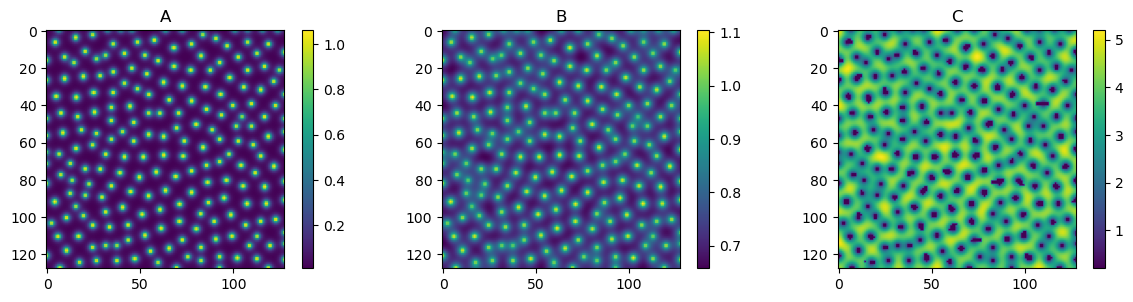

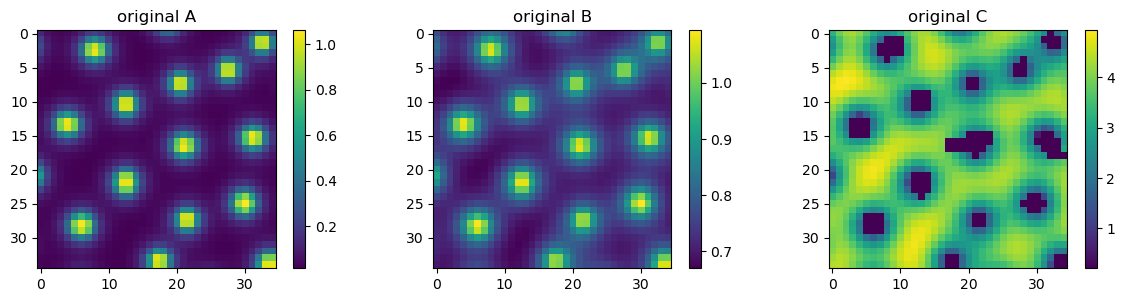

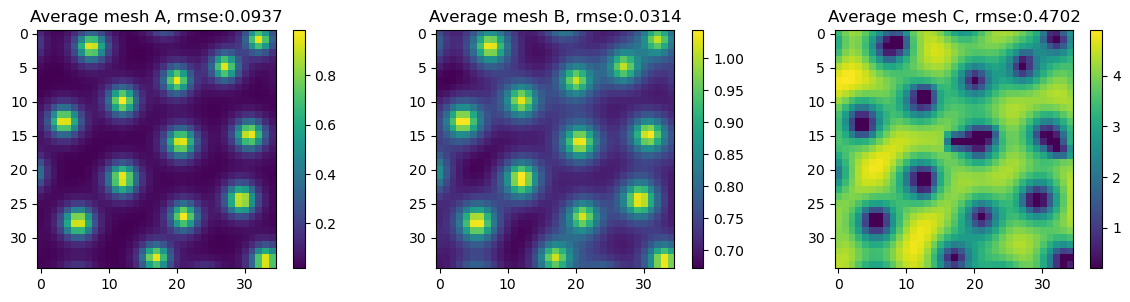

noise level:0.005, A amplitude:0.965635051607858, B amplitude:0.37279304494055954, C amplitude:4.69610922643436,
A noise std:0.00482817525803929, B noise std:0.0018639652247027978, C noise std:0.0234805461321718.


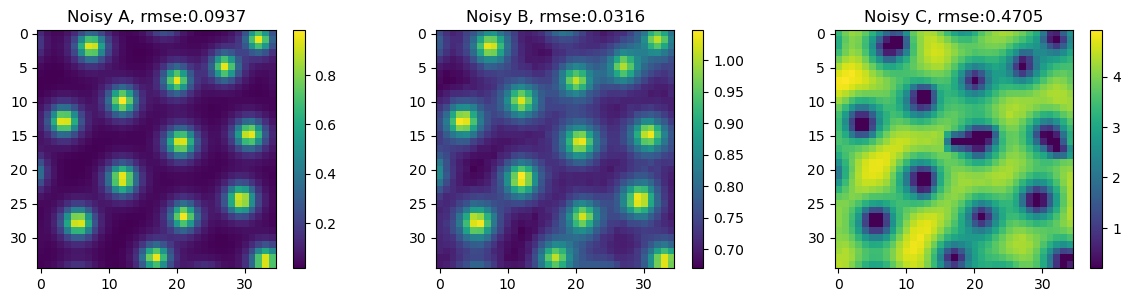

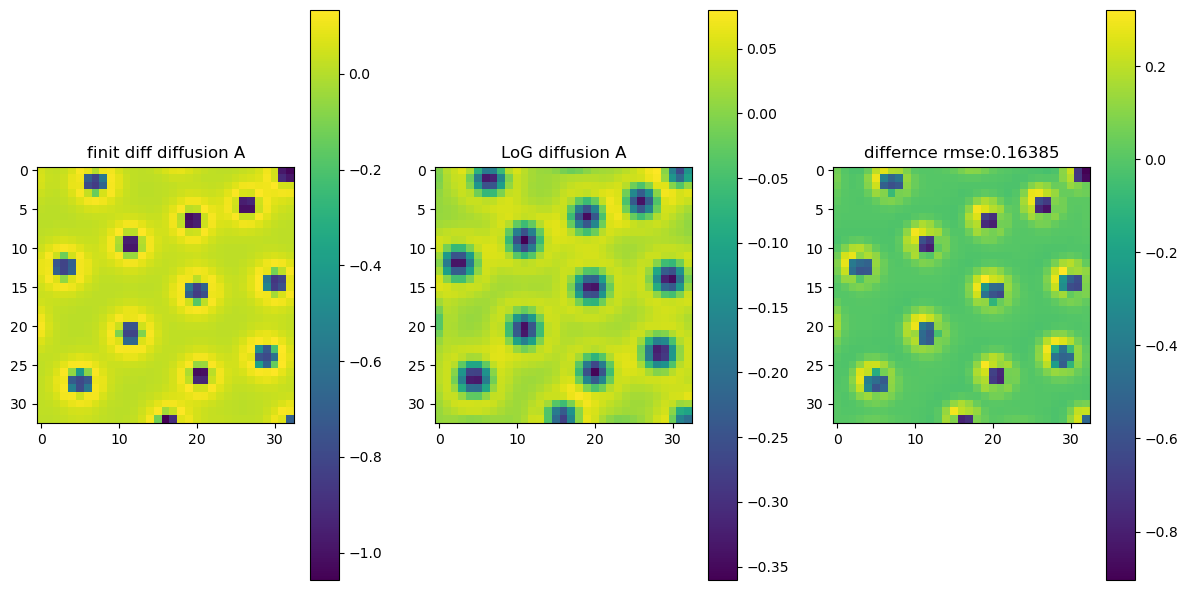

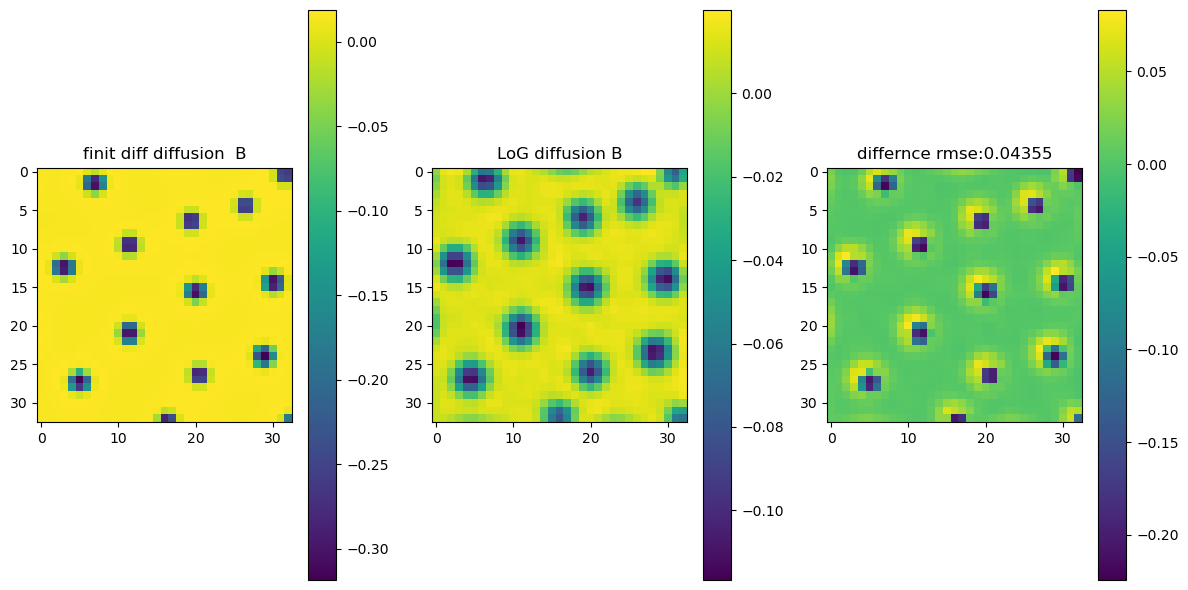


Start of epoch 0
observation loss: 0.06423964351415634, 0.6232118606567383, 11.205606460571289
total observation loss: 11.893057964742184
validation loss: 1.073428988456726, 4.617834091186523, 57.69307327270508
total validation loss: 63.38433837890625
at epoch 0, total loss: 11.900567066797521
l2_res_A_rhs: 0.00673818, l2_res_B_rhs: 0.00077093, l2_A: 0.06423964, l2_B: 0.62321186, l2_C: 11.20560646
Time taken: 9.08s


KeyboardInterrupt: 

In [24]:
index = 39
(pinn1,
     optimizer1, train_step_inverse1,names1, print_callback1,
     w1_1, w1_2, w1_3, w1_4, w1_5, w1_6, w1_7, w1_8,
     losses1,
     validation_loss1,ds_validation1, ds_train1, min_validation_1
) = simulation(index, 
               obserrvaion_sigma = 0,
               LoG_sigma = .75,
               test_validation_ratio=0.9,
               noise_level=0.00/2,
               epochs=20000+1, epochs2=20000+1, epochs3=20000+1,
               slice_min = 65, 
               slice_max = 100,
               run="1")
#########################
(pinn2,
     optimizer2, train_step_inverse2,names2, print_callback2,
     w2_1, w2_2, w2_3, w2_4, w2_5, w2_6, w2_7, w2_8,
     losses2,
     validation_loss2,ds_validation2, ds_train2, min_validation_2
) = simulation(index, 
               obserrvaion_sigma = 1.2,
               LoG_sigma = .75,
               test_validation_ratio=0.9,
               noise_level=0.01/2,
               epochs=20000+1, epochs2=20000+1, epochs3=20000+1,
               slice_min = 65, 
               slice_max = 100,
               run="2")
#########################
(pinn3,
     optimizer3, train_step_inverse3,names3, print_callback3,
     w3_1, w3_2, w3_3, w3_4, w3_5, w3_6, w3_7, w3_8,
     losses3,
     validation_loss3,ds_validation3, ds_train3, min_validation_3
) = simulation(index, 
               obserrvaion_sigma = 1.2,
               LoG_sigma = .75,
               test_validation_ratio=0.9,
               noise_level=0.02/2,
               epochs=20000+1, epochs2=20000+1, epochs3=20000+1,
               slice_min = 65, 
               slice_max = 100,
               run="3")
#########################
(pinn4,
     optimizer4, train_step_inverse4,names4, print_callback4,
     w4_1, w4_2, w4_3, w4_4, w4_5, w4_6, w4_7, w4_8,
     losses4,
     validation_loss4,ds_validation4, ds_train4, min_validation_4
) = simulation(index, 
               obserrvaion_sigma = 1.2,
               LoG_sigma = .75,
               test_validation_ratio=0.9,
               noise_level=0.05/2,
               epochs=20000+1, epochs2=20000+1, epochs3=20000+1,
               slice_min = 65, 
               slice_max = 100,
               run="3")

In [14]:
'b_A': 0.001, 'b_B': 1.0, 'b_C': 0.1, 'V_A': 100.0, 'V_B': 100.0
'V_C': 10.0,  'K_AA': 1.0, 'K_AB': 1.0, 'K_AC': 1.0, 
'K_BA': 0.5, 'K_BC': 0.5, 'K_CB': 25.0, 'K_CC': 1.0

In [18]:
(pinn1,
     optimizer1, train_step_inverse1,names, print_callback1,
     w1, w2, w3, w4, w5, w6, w7, w8,
     losses,
     validation_loss,ds_validation, ds, min_validation) = results



In [25]:
pinn2= tu.NN.restore(".", "pinn1_best_validation_PINN_net_output_only_and_alienor")

In [19]:
def create_epoch_callback(validation_loss):
    def epoch_callback1(epoch, loss_samples, index):            
        outputs = pinn1.net(ds_list_validation[:, 0, :])
        Ag = outputs[:, 0]
        Bg = outputs[:, 1]
        Cg = outputs[:, 2]

        A = ds_list_validation[:, 1, :][:, 0]
        B = ds_list_validation[:, 1, :][:, 1]
        C = ds_list_validation[:, 1, :][:, 2] 
        l2_res_A = np.mean((A - Ag)**2)
        l2_res_B = np.mean((B - Bg)**2)
        l2_res_C = np.mean((C - Cg)**2)    

        validation_loss[epoch, : ] = (l2_res_A, l2_res_B, l2_res_C)
        if epoch%1000==0:
            print(f"observation loss: {loss_samples[index, -3]}, {loss_samples[index, -2]}, {loss_samples[index, -1]}")
            print(f"total observation loss: {np.sum(loss_samples[index, -3:])}")
            print(f"validation loss: {l2_res_A}, {l2_res_B}, {l2_res_C}")
            print(f"total validation loss: {l2_res_A + l2_res_B + l2_res_C}")
    return epoch_callback1

epochs4 = 50000+1
params_est4 = np.zeros((epochs4, len(params_trainable1)))
validation_loss4 = np.zeros((epochs4, 3))
epoch_callback4 = create_epoch_callback(validation_loss4)



In [27]:
def to(arr):
    return arr.reshape(128, 128)

def to2(arr):
    return arr.numpy().reshape(block_x, block_y)

def to3(arr):
    return arr.reshape(128, 128)[x_slice, y_slice]

index = 39
print("######################################################")
path = subnet_df["path"].iloc[index]
print(index, path)
(params, res, k_max) = load_dataset(path)

T=1    
L=10
data = reshape(res, T)
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]
##########################################
# Create a mesh that is the centers of the
# original mesh
x_size -= 1
y_size -= 1
dxdy = L**2/((x_size-1)*(y_size-1))
#####
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]


x_slice = slice(65, 100, 1)
y_slice = slice(65, 100, 1)


x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)    
########################################
# Take the average of data points
kernel =np.array([[1, 1],
                  [1, 1]])


data2 = np.stack([[ (ndimage.convolve(data[i, :, :, j], kernel)/4)[x_slice, y_slice] 
                        for j in  range(data.shape[3])]
                        for i in  range(data.shape[0])])
data2 = np.einsum("ctxy -> cxyt", data2)
############################################
c_xx_out =  np.array([[second_order_derivatives((128, 128), data[c, ..., t])[0]
                for t in range(data.shape[3])]
                for c in range(data.shape[0])
               ])
c_xx_out = np.einsum("ctij -> cijt", c_xx_out)
c_yy_out = np.array([[second_order_derivatives((128, 128), data[c, ..., t])[1]
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy_out = np.einsum("ctij -> cijt", c_yy_out)

A_finit_diff_der = ( c_xx_out[0,:, :  , -1] + c_yy_out[0,:, :  , -1])[x_slice, y_slice]
B_finit_diff_der = ( c_xx_out[1,:, :  , -1] + c_yy_out[1,:, :  , -1])[x_slice, y_slice]

############################################
data_temp = np.stack([[ (ndimage.convolve(data[i, :, :, j], kernel)/4)
                        for j in  range(data.shape[3])]
                        for i in  range(data.shape[0])])
data_temp = np.einsum("ctxy -> cxyt", data_temp)
c_xx_out2 =  np.array([[second_order_derivatives((128, 128), data_temp[c, ..., t])[0]
                for t in range(data_temp.shape[3])]
                for c in range(data_temp.shape[0])
               ])
c_xx_out2 = np.einsum("ctij -> cijt", c_xx_out2)
c_yy_out2 = np.array([[second_order_derivatives((128, 128), data_temp[c, ..., t])[1]
                    for t in range(data_temp.shape[3])]
                    for c in range(data_temp.shape[0])
                   ])
c_yy_out2 = np.einsum("ctij -> cijt", c_yy_out2)

A_finit_diff_der_avg = ( c_xx_out2[0,:, :  , -1] + c_yy_out2[0,:, :  , -1])[x_slice, y_slice]
B_finit_diff_der_avg = ( c_xx_out2[1,:, :  , -1] + c_yy_out2[1,:, :  , -1])[x_slice, y_slice]

######################################################
39 outputs_second_search/solution_10_11_27.npy


In [28]:
@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg)
           )                

In [30]:
(A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
) = grads(pinn2, H)
A = to2(A).copy()
B = to2(B).copy()
C = to2(C).copy()
A_diff = to2((A_xx + A_yy))
B_diff = to2((B_xx + B_yy))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


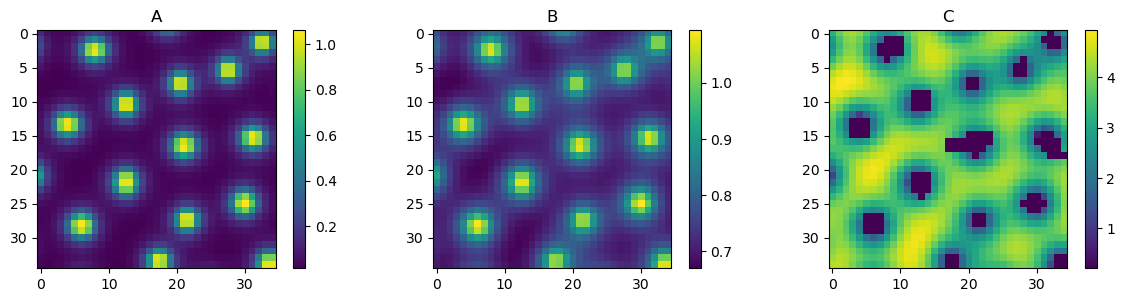

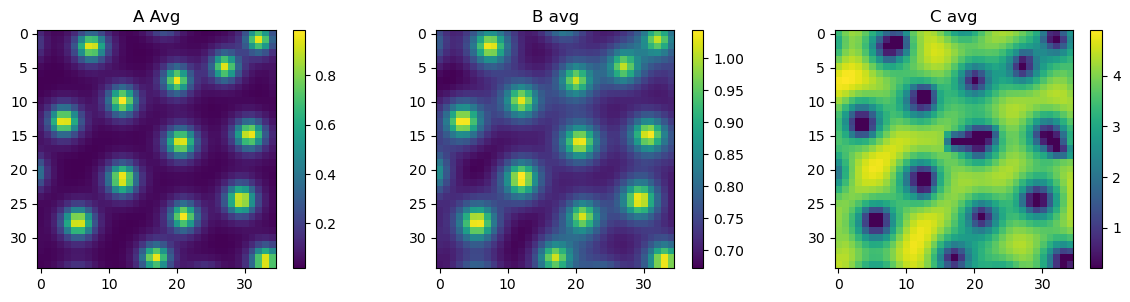

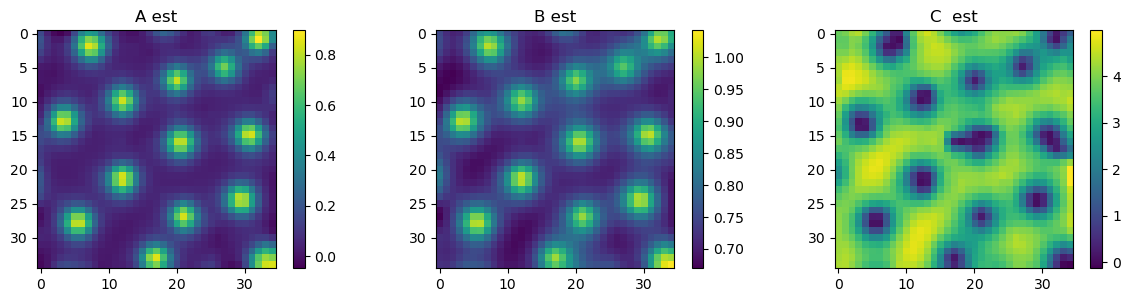

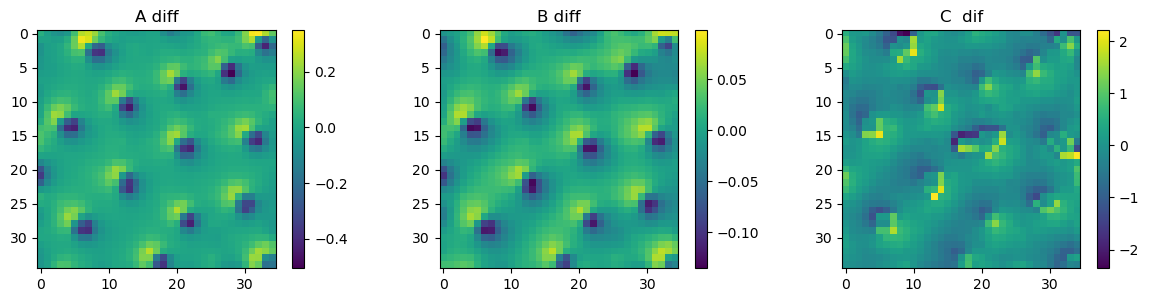

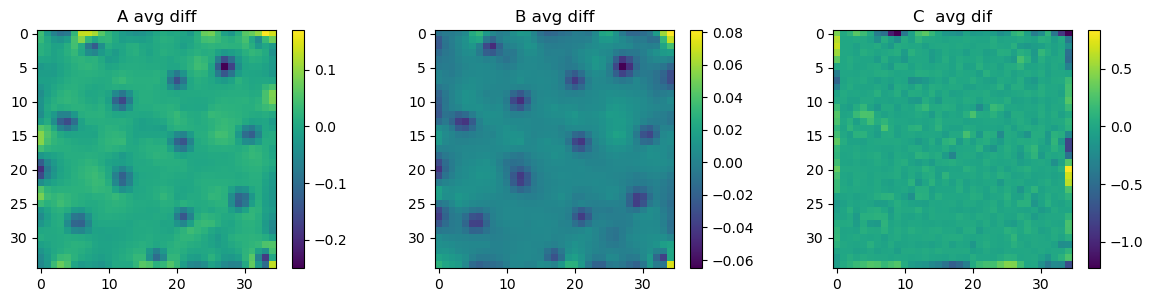

In [31]:
plot_n_im([to3(res[-1, 0, :]), to3(res[-1, 1, :]), to3(res[-1, 2, :])], 
      ["A", "B", "C"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([data2[0, :,:, -1], data2[1, :,:, -1], data2[2, :,:, -1]], 
      ["A Avg", "B avg", "C avg"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()


plot_n_im([A, B, C], 
      ["A est", "B est", "C  est"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A-to3(res[-1, 0, :]), B-to3(res[-1, 1, :]), C-to3(res[-1, 2, :])], 
      ["A diff", "B diff", "C  dif"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A-data2[0, :,:, -1], B-data2[1, :,:, -1], C-data2[2, :,:, -1]], 
      ["A avg diff", "B avg diff", "C  avg dif"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

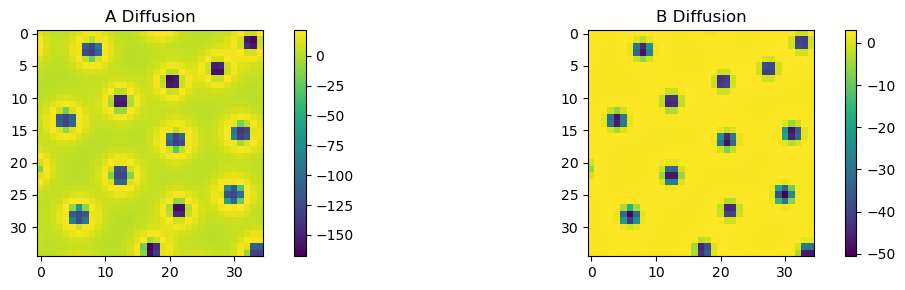

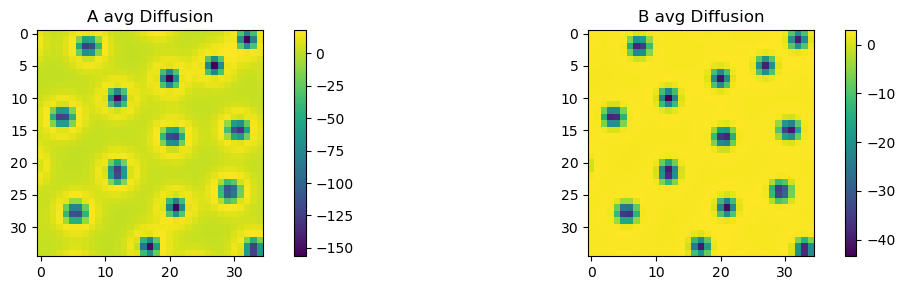

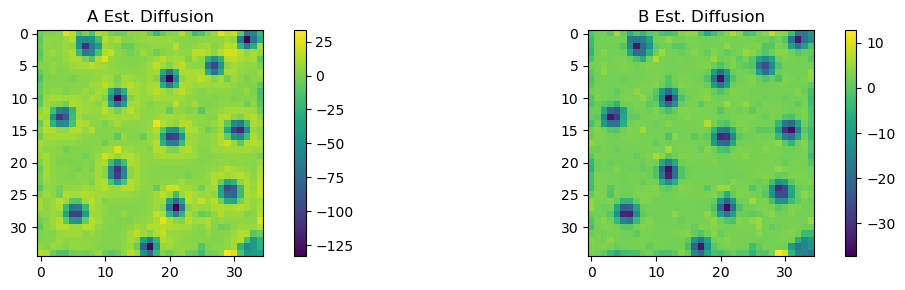

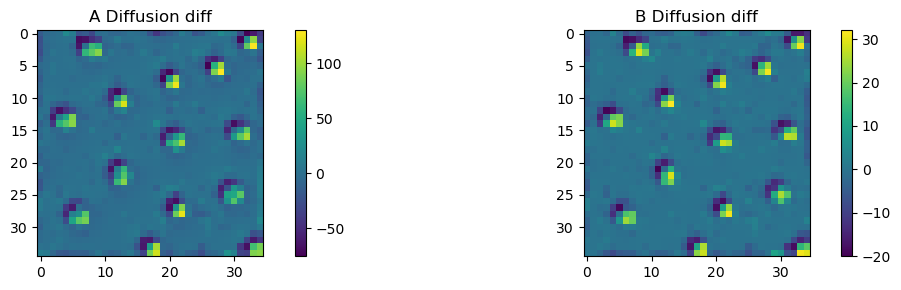

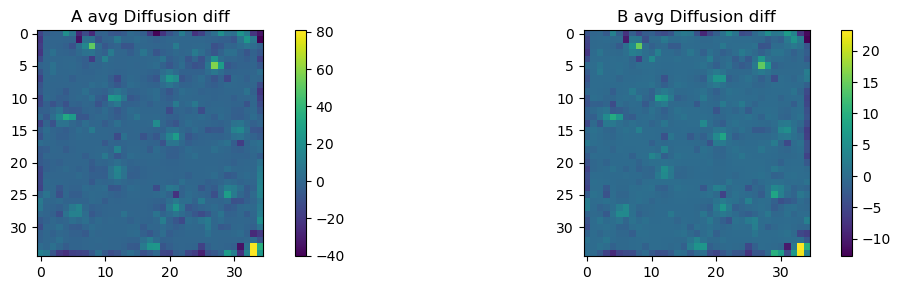

In [32]:
plot_n_im([A_finit_diff_der/dxdy, B_finit_diff_der/dxdy], 
      ["A Diffusion", "B Diffusion"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A_finit_diff_der_avg/dxdy, B_finit_diff_der_avg/dxdy], 
      ["A avg Diffusion", "B avg Diffusion"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A_diff, B_diff], 
      ["A Est. Diffusion", "B Est. Diffusion"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()


plot_n_im([A_diff-A_finit_diff_der/dxdy, B_diff-B_finit_diff_der/dxdy], 
      ["A Diffusion diff", "B Diffusion diff"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A_diff-A_finit_diff_der_avg/dxdy, B_diff-B_finit_diff_der_avg/dxdy], 
      ["A avg Diffusion diff", "B avg Diffusion diff"],          
      figsize=(12, 3)); plt.tight_layout();plt.show()

In [33]:
from scipy.optimize import minimize

def cos_dist(arr1, arr2):
    arr1_L = np.sqrt(np.dot(arr1, arr1))
    arr2_L = np.sqrt(np.dot(arr2, arr2))
    return np.dot(arr1, arr2)/(arr1_L*arr2_L)

def alienor_components2(epsilon, l1, bounds):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b,1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i]
        # alphas[i-1] (alpha/pi) / (|b_i| + |a_i|)
        alphas[i] = alpha*alphas[i-1]/(np.pi*(np.abs(b)+np.abs(a)))
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2         
        h_i = h_i = get_h_i(a,b,alphas[i])#
        h_list.append(h_i)        
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(np.abs(d[1])+np.abs(d[0]))**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    #
    theta_max = np.pi/alphas[-1]    
    return alpha, alphas, l2, h_list, theta_max

def minim_2(epsilon, l1, bounds, func, maxiter=10000):
    alpha, alphas, l2, h_list, theta_max = alienor_components2(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    theta = epsilon / L    
    theta_epsilon = theta
    
    f = lambda t: func(*[ h(t) for h in h_list])
    f_epsilon = f_theta = f(theta_epsilon)
    
    while k < maxiter:
        if theta > np.pi/alphas[-1]:            
            return k, theta,theta_epsilon, f_epsilon, ""
        
        theta = theta + (epsilon + f_theta - f_epsilon)/ L        
        f_theta  =  f(theta)
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        k += 1    
    return k, theta,theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached"

In [55]:

path = subnet_df["path"].iloc[index]
print(index, path)
(params, res_1, k_max) = load_dataset(path)

n_val = params["n"]
mu_A_val, mu_B_val, mu_C_val = params["mu_A"], params["mu_B"], params["mu_C"]



bounds_A = [(0,30), (0,200), (0,30), (0,30)]
bounds_B = [(0,30), (0,200), (0,30), (0,30)]
bounds_C = [(0,30), (0,200), (0,30), (0,30), (0,30)]
epsilon = 1e-3
l1 = 1

alpha_A, alphas_A, l2_A, h_list2_A, theta_max2_A = alienor_components2(epsilon, l1, bounds_A)
alpha_B, alphas_B, l2_B, h_list2_B, theta_max2_B = alienor_components2(epsilon, l1, bounds_B)
alpha_C, alphas_C, l2_C, h_list2_C, theta_max2_C = alienor_components2(epsilon, l1, bounds_C)
L_A = l1*l2_A
L_B = l1*l2_B
L_C = l1*l2_C
print("delta theta A:", epsilon/L_A)
print("delta theta A:", L_A/epsilon)
print()
print("delta theta B:", epsilon/L_B)
print("delta theta B:", L_B/epsilon)
print()
print("delta theta C:", epsilon/L_C)
print("delta theta C:", L_C/epsilon)

batch_size = 10000
print("A epochs:", L_A/epsilon/batch_size)
print("B epochs:", L_B/epsilon/batch_size)
print("C epochs:", L_C/epsilon/batch_size)

thetas_A = np.linspace(0, theta_max2_A,  int(L_A/epsilon))
thetas_B = np.linspace(0, theta_max2_B,  int(L_B/epsilon))
thetas_C = np.linspace(0, theta_max2_C,  int(L_C/epsilon))

params_by_theta_A = np.stack([h_list2_A[0](thetas_A), h_list2_A[1](thetas_A),
                              h_list2_A[2](thetas_A), h_list2_A[3](thetas_A)]).T

params_by_theta_B = np.stack([h_list2_B[0](thetas_B), h_list2_B[1](thetas_B),
                              h_list2_B[2](thetas_B), h_list2_B[3](thetas_B)]).T

params_by_theta_C = np.stack([h_list2_C[0](thetas_C), h_list2_C[1](thetas_C),
                              h_list2_C[2](thetas_C), h_list2_C[3](thetas_C),
                              h_list2_C[4](thetas_C)]).T

theta_A_n = params_by_theta_A.shape[0]
theta_A_m = params_by_theta_A.shape[1]
theta_B_n = params_by_theta_B.shape[0]
theta_B_m = params_by_theta_B.shape[1]
theta_C_n = params_by_theta_C.shape[0]
theta_C_m = params_by_theta_C.shape[1]

D_A = params["D_A"]
D_B = params["D_B"]

def Create_f_A(A, B, C, n, mu_A, A_diffu=None):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A#.flatten()[np.newaxis, :]
    B_flat = B#.flatten()[np.newaxis, :]   
    print(A_flat.shape)
    print(B_flat.shape)
    print(A_diffu.shape)
    #A_diffu =  0.01* diffu_2D(A).flatten()[np.newaxis, :]
    if A_diffu is None:
        dxdy = (10*10)/((A.shape[0]-1)*(A.shape[1]-1))
        A_diffu = ((1.0/dxdy)*(diffusion((A.shape[0],A.shape[1]),A))).flatten()[np.newaxis, :]

    def L_2_f_a(args):
        (b_A, V_A,  K_AA, K_BA
        ) = (args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4])
        f1 = (b_A + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - mu_A*A_flat 
              + D_A*A_diffu)
        f2 = (b_A/(D_A+1e-6) + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n)/(D_A+1e-6) 
              - mu_A*A_flat/(D_A+1e-6) + A_diffu)

        return np.sum((f1**2 + f2**2 )/A_flat.size, axis=1)
    return L_2_f_a

def Create_f_A_1_D(A, B, C, n, mu_A, A_diffu=None):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A#.flatten()[np.newaxis, :]
    B_flat = B#.flatten()[np.newaxis, :]    
    #A_diffu =  0.01* diffu_2D(A).flatten()[np.newaxis, :]
    if A_diffu is None:
        dxdy = (10*10)/((A.shape[0]-1)*(A.shape[1]-1))
        A_diffu = ((1.0/dxdy)*(diffusion((A.shape[0],A.shape[1]),A))).flatten()[np.newaxis, :]
    def L_2_f_a(args):        
        (b_A,V_A, K_AA, K_BA
        ) = (args[0], args[1], args[2], args[3])
        f1 = (b_A + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - mu_A*A_flat 
              + D_A*A_diffu)
        f2 = (b_A/(D_A+1e-6) + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n)/(D_A+1e-6) 
              - mu_A*A_flat/(D_A+1e-6) + A_diffu)

        return np.sum((f1**2 + f2**2 )/A_flat.size, axis=1)
    return L_2_f_a

def Create_f_B(A, B, C, n, mu_B, B_diffu=None):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A#.flatten()[np.newaxis, :]
    B_flat = B#.flatten()[np.newaxis, :]   
    C_flat = C#.flatten()[np.newaxis, :]
    #B_diffu =  1.0* diffu_2D(B).flatten()[np.newaxis, :]
    if B_diffu is None:
        dxdy = (10*10)/((B.shape[0]-1)*(B.shape[1]-1))
        B_diffu = ((1.0/dxdy)*(diffusion((B.shape[0],B.shape[1]),B))).flatten()[np.newaxis, :]    
    def L_2_f_b(args):
        (b_B, V_B, K_AB, K_CB
        ) = (args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4])
        f1 = (b_B + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - mu_B*B_flat 
             + D_B*B_diffu)
        f2 = (b_B/(D_B + 1e-6) + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n)/(D_B + 1e-6)
              - mu_B*B_flat/(D_B + 1e-6)  + B_diffu)
        return np.sum((f1**2 + f2**2 )/B_flat.size, axis=1)
    return L_2_f_b

def Create_f_B_1_D(A, B, C, n, mu_B, B_diffu=None):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A#.flatten()[np.newaxis, :]
    B_flat = B#.flatten()[np.newaxis, :]   
    C_flat = C#.flatten()[np.newaxis, :]
    #B_diffu =  1.0* diffu_2D(B).flatten()[np.newaxis, :]
    if B_diffu is None:
        dxdy = (10*10)/((B.shape[0]-1)*(B.shape[1]-1))
        B_diffu = ((1.0/dxdy)*(diffusion((B.shape[0],B.shape[1]),B))).flatten()[np.newaxis, :]
    def L_2_f_b(args):        
        (b_B, V_B,K_AB, K_CB
        )  = (args[0], args[1], args[2], args[3])
        f1 = (b_B + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - mu_B*B_flat 
             + D_B*B_diffu)
        f2 = (b_B/(D_B + 1e-6) + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n)/(D_B + 1e-6)
              - mu_B*B_flat/(D_B + 1e-6)  + B_diffu)
        return np.sum((f1**2 + f2**2 )/B_flat.size, axis=1)
    return L_2_f_b

def Create_f_C(A, B, C, n, mu_C):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A#.flatten()[np.newaxis, :]
    B_flat = B#.flatten()[np.newaxis, :]   
    C_flat = C#.flatten()[np.newaxis, :]
    def L_2_f_c(args):
        b_C, V_C, K_AC, K_BC, K_CC = args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4], args[:, 4:5]
        #b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
        f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
        return np.sum(f**2, axis=1)
    return L_2_f_c

def Create_f_C_1_D(A, B, C, n, mu_C):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A#.flatten()[np.newaxis, :]
    B_flat = B#.flatten()[np.newaxis, :]   
    C_flat = C#.flatten()[np.newaxis, :]
    def L_2_f_c(args):        
        b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
        f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
        return np.sum(f**2)
    return L_2_f_c



39 outputs_second_search/solution_10_11_27.npy
delta theta A: 2.222222222222222e-06
delta theta A: 450000.0

delta theta B: 2.222222222222222e-06
delta theta B: 450000.0

delta theta C: 2.222222222222222e-06
delta theta C: 450000.0
A epochs: 45.0
B epochs: 45.0
C epochs: 45.0


In [85]:
from multiprocessing import Pool, shared_memory

@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg)
           )                               

class _LocalFunctions:
    @classmethod
    def add_functions(cls, *args):
        for function in args:
            setattr(cls, function.__name__, function)
            function.__qualname__ = cls.__qualname__ + '.' + function.__name__

def minimise_one(pinn, H, simulate_from_start=True):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)
    #outputs = pinn.net(flatten(H))
    
    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
    ) = grads(pinn, H)
#     A = to(A)[1:-1, 1:-1].copy()
#     B = to(B)[1:-1, 1:-1].copy()
#     C = to(C)[1:-1, 1:-1].copy()
    A = A.numpy().copy()# to(A).copy()
    B = B.numpy().copy()#to(B).copy()
    C = C.numpy().copy()#to(C).copy()
    A_diff = (A_xx + A_yy).numpy()#[np.newaxis, :]
    B_diff = (B_xx + B_yy).numpy()#[np.newaxis, :]
    print(A.shape)
    indices = np.argwhere(np.logical_and(A_diff < 1000, A_diff > -1000) & 
                          np.logical_and(B_diff < 1000 , B_diff > -1000))
    A = A[indices].T#[np.newaxis, :]
    B = B[indices].T#[np.newaxis, :]
    C = C[indices].T#[np.newaxis, :]
    A_diff = A_diff[indices].T#[np.newaxis, :]
    B_diff = B_diff[indices].T#[np.newaxis, :]
    #print(A.shape, B.shape, A_diff.shape)
    
    #print(A_diff.shape)
    #A_diff = c_diffusion_flatten[:, 1][np.newaxis, :].numpy().copy()
    #B_diff = c_diffusion_flatten[:, 2][np.newaxis, :].numpy().copy()
    #print(A_diff.shape)
    
    f_a_loss = Create_f_A(A, B, C, 4, params["mu_A"], A_diff)
    f_a_loss_1_D = Create_f_A_1_D(A, B, C, 4, params["mu_A"], A_diff)
    f_b_loss = Create_f_B(A, B, C, 4, params["mu_B"], B_diff)
    f_b_loss_1_D = Create_f_B_1_D(A, B, C, 4, params["mu_B"], B_diff)
    f_c_loss = Create_f_C(A, B, C, 4, params["mu_C"])
    f_c_loss_1_D = Create_f_C_1_D(A, B, C, 4, params["mu_C"])
    
    
    def singA(args):
        batch_id,theta_n,theta_m= args 
        params_shm = shared_memory.SharedMemory(name="params_by_theta3")
        output_shm = shared_memory.SharedMemory(name="outputs3")
        thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
        f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
        f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_a_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
        return batch_id

    def singB(args):
        batch_id,theta_n,theta_m= args 
        params_shm = shared_memory.SharedMemory(name="params_by_theta3")
        output_shm = shared_memory.SharedMemory(name="outputs3")
        thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
        f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
        f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_b_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
        return batch_id

    def singC(args):
        batch_id,theta_n,theta_m= args 
        params_shm = shared_memory.SharedMemory(name="params_by_theta3")
        output_shm = shared_memory.SharedMemory(name="outputs3")
        thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
        f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
        f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_c_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
        return batch_id

    _LocalFunctions.add_functions(singA, singB, singC)
    
    def run(theta_n,theta_m,params_by_theta, sing, L, epsilon, batch_size):
        shm = shared_memory.SharedMemory(name="params_by_theta3",create=True, size=params_by_theta.nbytes)
        shared_thetas = np.ndarray((theta_n,theta_m), dtype=np.float64,
                                    buffer=shm.buf)

        shared_thetas[:,:] = params_by_theta[:,:]


        f_thetas = np.zeros(theta_n)
        shm_out = shared_memory.SharedMemory(name="outputs3",create=True, size=f_thetas.nbytes)
        shared_outputs = np.ndarray((theta_n), dtype=np.float64,
                                     buffer=shm_out.buf)

        
        args =[ (batch_id, theta_n,theta_m) for batch_id in range(int(L/epsilon/batch_size) + 1)]

        with Pool(55) as pool:
            res = pool.map(sing, args)

        f_thetas[:] = shared_outputs[:]
        shm.close()
        shm.unlink()

        shm_out.close()
        shm_out.unlink()

        return f_thetas
     
    f_thetas_A = run(theta_A_n,theta_A_m,params_by_theta_A, singA, L_A, epsilon, batch_size)
    f_thetas_B = run(theta_B_n,theta_B_m,params_by_theta_B, singB, L_B, epsilon, batch_size)
    f_thetas_C = run(theta_C_n,theta_C_m,params_by_theta_C, singC, L_C, epsilon, batch_size)
     

    def minimise_top_n(n, h_list, bounds, loss_1_D, f_thetas, thetas):
        shift = 0
        init_params = np.zeros((n, len(h_list)))
        final_params = np.zeros((n, len(h_list)))
        init_loss = np.zeros(n)
        final_loss = np.zeros(n)

        top_n = np.argpartition(-f_thetas, -n)[-n:]
        top_n = top_n[np.argsort(f_thetas[top_n])]

        for shift in range(n):

            theta_star = thetas[top_n][0 + shift]
            init_par = tuple([h(theta_star) for h in h_list])
            init_params[shift, :] = init_par
            init_loss[shift] = f_thetas[top_n][0 + shift]
            #bounds = ((0, 200), (0, 200), (0, 200), (0, 200), (0, 200))
            res3= minimize(loss_1_D, x0=init_par, method='L-BFGS-B', bounds=bounds)#, options={'ftol':1e-10})
            final_params[shift, :] = res3['x']
            final_loss[shift] = res3['fun']

        sorted_loss_ind = np.argsort(final_loss)
        init_params = init_params[sorted_loss_ind.tolist()]
        init_loss = init_loss[sorted_loss_ind.tolist()]
        final_params = final_params[sorted_loss_ind.tolist()]
        final_loss = final_loss[sorted_loss_ind.tolist()]

        return (final_loss, final_params, init_loss, init_params )
    n_max = 20
    (final_loss_A, final_params_A, 
     init_loss_A, init_params_A) = minimise_top_n(n_max, h_list2_A, 
                                                  ((0, 500), (0, 500), (0, 500), (0, 500)), 
                                                  f_a_loss_1_D, f_thetas_A, thetas_A)

    (final_loss_B, final_params_B, 
     init_loss_B, init_params_B) = minimise_top_n(n_max, h_list2_B, 
                                                  ((0, 500), (0, 500), (0, 500), (0, 500)), 
                                                  f_b_loss_1_D, f_thetas_B, thetas_B)

    (final_loss_C, final_params_C, 
     init_loss_C, init_params_C) = minimise_top_n(n_max, h_list2_C, 
                                                  ((0, 500), (0, 500), (0, 500), (0, 500), (0, 500)), 
                                                  f_c_loss_1_D, f_thetas_C, thetas_C)
    
    
    for i in range(n_max):
        
        b_A_val, V_A_val,  K_AA_val,  K_BA_val = final_params_A[i]
        b_B_val, V_B_val,  K_AB_val,  K_CB_val = final_params_B[i]
        b_C_val, V_C_val,  K_AC_val,  K_BC_val, K_CC_val = final_params_C[i]
        mu_A_val = params["mu_A"]
        mu_B_val = params["mu_B"]
        mu_C_val = params["mu_C"]
        
        actual_params = np.array(list(params.values())[3:])
        estimated_params = np.array(
            [b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val,
             K_AC_val, b_B_val, mu_B_val, V_B_val, K_BA_val,
             K_BC_val, b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val])
        ###############################
        print("="*40)
        print(f"{i}: Minimisation")
        print()
        print(f"b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
              f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
              f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
              f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
              f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
              f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")  
        print("")
        print(f"Difference norm: {np.linalg.norm(actual_params-estimated_params)}")
        print(f"Cos distance   : {cos_dist(actual_params, estimated_params)}")
        print("="*40)

        kinetics = create_circuit_3954(n_val, 
                                       b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                                       b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                                       b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  
        if simulate_from_start:
            A_init = res_1[0, 0, :]
            B_init = res_1[0, 1, :]
            C_init = res_1[0, 2, :]
            res_2 = model_128_10.integrate([A_init,B_init,C_init], kinetics, 5000-1, 1)
        else:
            A_init = res_1[-1, 0, :]
            B_init = res_1[-1, 1, :]
            C_init = res_1[-1, 2, :]
            res_2 = model_128_10.integrate([A_init,B_init,C_init], kinetics, 4*5000-1, 1)
        

        A1 = res_1[-1, 0, :]
        B1 = res_1[-1, 1, :]
        C1 = res_1[-1, 2, :]
        def to(arr):
            return arr.reshape(128, 128)
        plot_n_im([to(A1), to(B1), to(C1)], 
                      ["A1", "B1", "C1"],          
                      figsize=(12, 3)); plt.tight_layout();plt.show()

        A2 = res_2[-1, 0, :]
        B2 = res_2[-1, 1, :]
        C2 = res_2[-1, 2, :] 
        plot_n_im([to(A2), to(B2), to(C2)], 
                      ["A2", "B2", "C2"],          
                      figsize=(12, 3)); plt.tight_layout();plt.show()

        plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
                      ["diff A", "diff B", "diff C"],          
                      figsize=(12, 3)); plt.tight_layout();plt.show()
        def RMSE(a1, a2):
            return np.sqrt(np.mean((a1-a2)**2, axis=1))
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
        plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
        plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
        plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

        plt.subplot(132)
        plt.plot(RMSE(res_2[1:, 0, :], res_2[:-1, 0, :]) , label="Auto A rmse")
        plt.plot(RMSE(res_2[1:, 1, :], res_2[:-1, 1, :]) , label="Auto B rmse")
        plt.plot(RMSE(res_2[1:, 2, :], res_2[:-1, 2, :]) , label="Auto C rmse")
        plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

        if simulate_from_start:
            steps = 500
        else:
            steps = 4*500
        plt.subplot(133)
        
        plt.plot(RMSE(res_1[:, 0, :], res_2[::steps, 0, :]) , label="A rmse")
        plt.plot(RMSE(res_1[:, 1, :], res_2[::steps, 1, :]) , label="B rmse")
        plt.plot(RMSE(res_1[:, 2, :], res_2[::steps, 2, :]) , label="C rmse")
        plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
        plt.show()


In [ ]:
minimise_one(pinn2, H)

In [ ]:
params_shm = shared_memory.SharedMemory(name="params_by_theta3")
output_shm = shared_memory.SharedMemory(name="outputs3")

params_shm.close()
params_shm.unlink()

output_shm.close()
output_shm.unlink()

In [26]:
D_A_val, D_B_val = 0.01, 1.0
N=5000
T=100
delta_t = T/N
model_128_10 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], delta_t=delta_t, Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D)

12 outputs_second_search/solution_10_10_103.npy
D_A:0.0100, D_B:1.0000, b_A:0.0223, mu_A:1.0000, V_A:2.3592, K_AA:0.6013, K_AB:0.2255, K_AC:8.6932, b_B:1.1681, mu_B:5.0000, V_B:40.8854, K_BA:11.0427, K_BC:0.5939, b_C:0.5024, mu_C:0.5000, V_C:5.1311, K_CB:1.1567, K_CC:2.1235


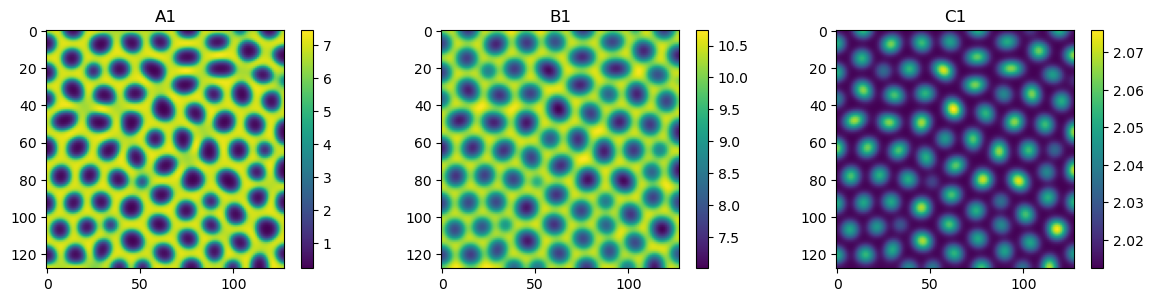

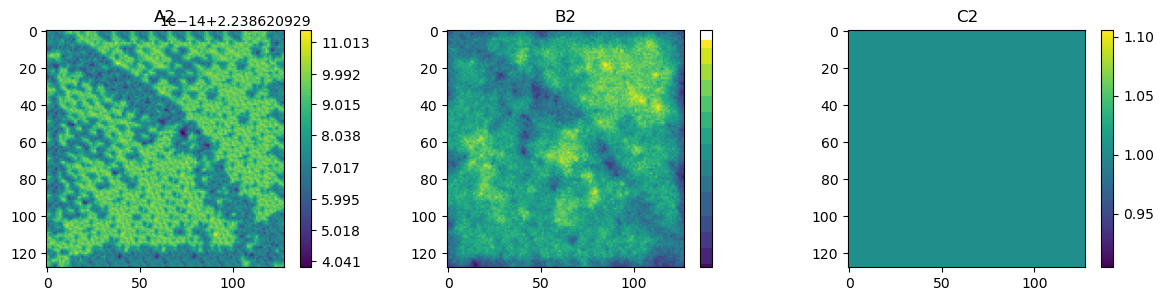

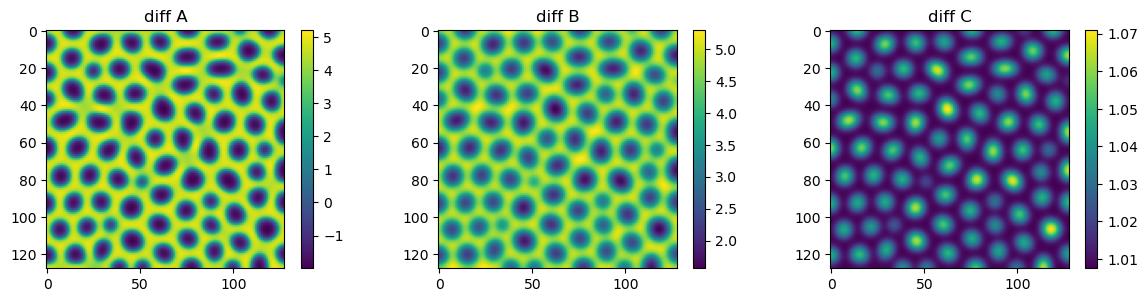

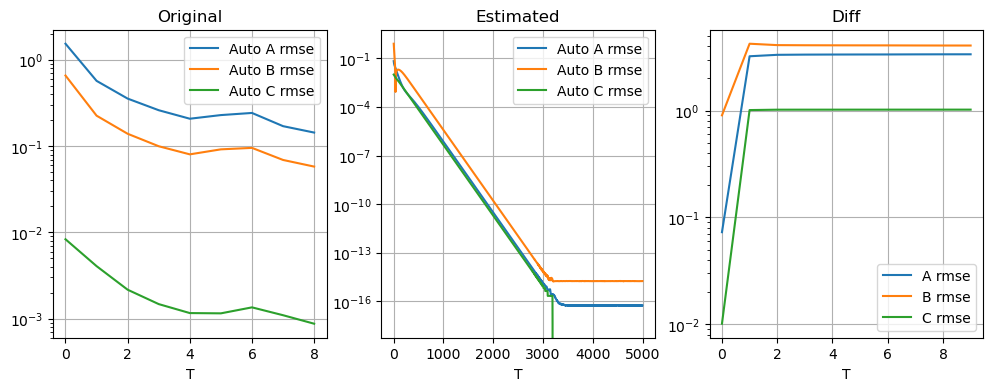

In [21]:
index = 12
path = subnet_df["path"].iloc[index]
print(index, path)
(params, res_1, k_max) = load_dataset(path)

n_val = params["n"]
mu_A_val, mu_B_val, mu_C_val = params["mu_A"], params["mu_B"], params["mu_C"]



print(f"D_A:{D_A_val:.4f}, D_B:{D_B_val:.4f}, b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
      f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
      f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
      f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
      f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
      f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")
kinetics = create_circuit_3954(n_val, 
                               b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                               b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                               b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)  

A_init = res_1[0, 0, :]
B_init = res_1[0, 1, :]
C_init = res_1[0, 2, :]
res_2 = model_128_10.integrate([A_init,B_init,C_init], kinetics, 5000-1, 1)

A1 = res_1[-1, 0, :]
B1 = res_1[-1, 1, :]
C1 = res_1[-1, 2, :]
plot_n_im([to(A1), to(B1), to(C1)], 
              ["A1", "B1", "C1"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

A2 = res_2[-1, 0, :]
B2 = res_2[-1, 1, :]
C2 = res_2[-1, 2, :] 
plot_n_im([to(A2), to(B2), to(C2)], 
              ["A2", "B2", "C2"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(A1)-to(A2), to(B1)-to(B2), to(C1)-to(C2)], 
              ["diff A", "diff B", "diff C"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()
def RMSE(a1, a2):
    return np.sqrt(np.mean((a1-a2)**2, axis=1))
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(RMSE(res_1[1:, 0, :], res_1[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_1[1:, 1, :], res_1[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_1[1:, 2, :], res_1[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Original")

plt.subplot(132)
plt.plot(RMSE(res_2[1:, 0, :], res_2[:-1, 0, :]) , label="Auto A rmse")
plt.plot(RMSE(res_2[1:, 1, :], res_2[:-1, 1, :]) , label="Auto B rmse")
plt.plot(RMSE(res_2[1:, 2, :], res_2[:-1, 2, :]) , label="Auto C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Estimated")

plt.subplot(133)
plt.plot(RMSE(res_1[:, 0, :], res_2[::500, 0, :]) , label="A rmse")
plt.plot(RMSE(res_1[:, 1, :], res_2[::500, 1, :]) , label="B rmse")
plt.plot(RMSE(res_1[:, 2, :], res_2[::500, 2, :]) , label="C rmse")
plt.legend();plt.grid();plt.xlabel("T");plt.yscale('log');plt.title("Diff")
plt.show()